In [1]:
from scipy import stats
import pymc3 as pm
import theano as tt
from theano import shared
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.stats import norm
np.random.seed(1234)




WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

In [387]:


def schon_basis(x, len=35.0):
    return len**(-1/2)* np.sin((np.pi*x)/2*len)

def gaussian_basis(x, mu, sigma):
    return norm(loc=mu, scale=sigma).pdf(x).astype(np.float32)

def _expand(x, bf, bf_args):
    return np.stack([bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def expand_schon(x, L=35):
    return _expand(x, bf=schon_basis, bf_args=range(1, L+ len(x)))

def expand_gaussian(x, mus=np.linspace(0, 1, 9), sigma=0.3):
    return _expand(x, bf=partial(gaussian_basis, sigma=sigma), bf_args=mus)


#expand = expand_schon
expand = expand_gaussian

[-30.  -29.5 -29.  -28.5 -28.  -27.5 -27.  -26.5 -26.  -25.5 -25.  -24.5
 -24.  -23.5 -23.  -22.5 -22.  -21.5 -21.  -20.5 -20.  -19.5 -19.  -18.5
 -18.  -17.5 -17.  -16.5 -16.  -15.5 -15.  -14.5 -14.  -13.5 -13.  -12.5
 -12.  -11.5 -11.  -10.5 -10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5
  -6.   -5.5  -5.   -4.5  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5
   0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5]


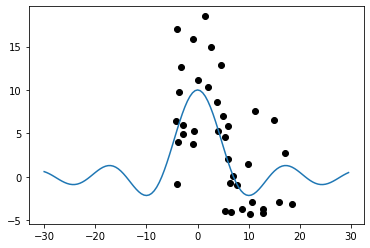

In [388]:

T = 40

x = np.zeros(shape=(1,T+1))
y = np.zeros(shape=(1,T+1))

def f_t(x, noise=0):
    return 10.0 * np.sinc(x/7) + np.random.normal(loc=0,scale=noise)
def g(x,noise=0):
    return x + + np.random.normal(loc=0,scale=noise)
Q,R=4.0, 4.0
x[:,0]= np.random.rand()*10.0
y[:,0] = x[:,0] + np.random.normal(loc=0, scale=R)
for i in range(1,T+1):
   
    x[:,i] = f_t(x[:,i-1], noise=Q)
    y[:,i]=g(x[:,i], noise=0)
    


#plt.scatter(x,y)
#print(len(x))
#print(len(y))
plt.scatter(x[:,1:T-1],x[:,2:T], c='k')
xv = np.arange(-30,30,0.5)
print(xv)
r_f_t = f_t(xv)
plt.plot(xv, r_f_t)


#print(x[0])

In [389]:
Phi = expand(x)
Phi.shape[2]
#Phi_shared = shared(Phi)


41

In [399]:
from theano import shared

Phi = expand(x)
Phi_shared = shared(Phi)

with pm.Model() as model:
    #w_0 = pm.Normal('w_0', mu=0, sigma=10)
    w_r = pm.Normal('w_r', mu=0, sigma=10)
    sigma=pm.HalfNormal('sigma',sigma=4)

    mu = w_r.dot(Phi.T)
    
    t_obs = pm.Normal('t_obs', mu=mu, sigma=sigma, observed=x)

In [400]:
with model:
    trace = pm.sample(return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w_r]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


/var/folders/v1/58yl0t_n2ng9vz587pfjhtpc0000gn/T/ipykernel_2279/3892976860.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=False)


array([[<AxesSubplot:title={'center':'w_r'}>,
        <AxesSubplot:title={'center':'w_r'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

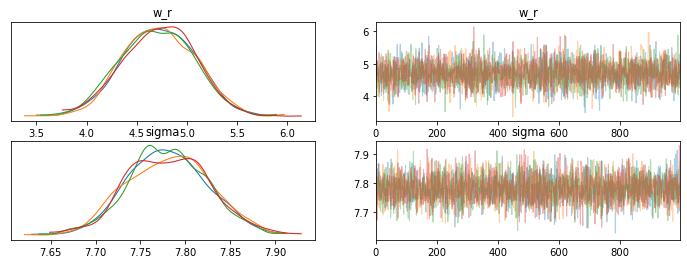

In [401]:
pm.traceplot(trace, compact=False)

In [402]:
#Phi_shared.set_value(expand(x_test))
predictive_samples = pm.sample_posterior_predictive(trace, model=model, samples=5000)['t_obs']

ValueError: x and y must have same first dimension, but have shapes (1, 41) and (41, 9, 41)

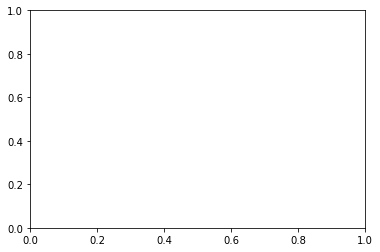

In [406]:
m = np.mean(predictive_samples, axis=0)
s = np.std(predictive_samples, axis=0)

#plt.fill_between(x, m + s, m - s, alpha = 0.5, label='Predictive std. dev.')
plt.plot(x, m, label='Predictive mean')

#plot_data(x, y)
plot_truth(x[1,:], y, label=None)

plt.legend()

20